In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
#Importing data
deliveries= pd.read_csv('deliveries.csv')
matches= pd.read_csv('matches.csv')


In [3]:
#Adding Some Columns to dfs

deliveries['is_legal']= 1-((deliveries.noball_runs + deliveries.wide_runs)>.5)
deliveries['is_dismissed']= 1- (deliveries.player_dismissed.isnull())
deliveries['is_dot']=1*(deliveries.total_runs<.1)
matches['win']=1*(matches.win_by_runs>0)


In [4]:
#Computing some aggregates from 'deliveries', incl. inns 1 score, inns 2 score

scores_dict={}
for i in deliveries.match_id.unique():
    
    df_match= deliveries[deliveries.match_id==i]
    
    df_1= df_match[df_match.inning==1]
    
    df_2= df_match[df_match.inning==2]
    
    df_last= df_match.tail(1)
    
    ov= np.array(df_last.over)[0]
    
    ov_df= df_2[df_2.over==ov]
    ba=sum(ov_df.is_legal)
    
    ov=20-ov
    
    ba=max(6-ba, 0)
    
    scores_dict[i]={}
    
    scores_dict[i]['id']= i
    
    scores_dict[i]['innings1']= df_1.total_runs.sum()
    
    scores_dict[i]['wickets1']= df_1.is_dismissed.sum()
    
    scores_dict[i]['maxover1']= max(df_1.over)
    
    scores_dict[i]['innings2']= df_2.total_runs.sum()
    
    scores_dict[i]['rem']= (scores_dict[i]['innings2']>scores_dict[i]['innings1'])*(6*ov + ba)
    
    scores_dict[i]['mar']= max(0,scores_dict[i]['innings2']- scores_dict[i]['innings1'])
    +  np.round(100*(scores_dict[i]['rem']* scores_dict[i]['innings1'])/120)/100
    

In [5]:
#Making a df out of my aggregates

scores_df= pd.DataFrame(scores_dict).T


In [6]:
#Merging that df with matches

match_df= pd.merge(matches, scores_df, on='id', how='right')


In [8]:
#Removing rain affected matches

no_rain= match_df[match_df.dl_applied==0]


In [9]:
#Removing no result/tied matches

no_rain=no_rain[no_rain.result=='normal']


In [10]:
#Removing more rain affected matches

no_rain['islegit']= (no_rain.wickets1>9.5) + (no_rain.maxover1>19.5)
no_rain=no_rain[no_rain['islegit']]


/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [11]:
#Giving the chasing team bonus runs 

no_rain['adj_inn2']=no_rain.innings2+no_rain.mar


In [12]:
#df of only team batting 2nd wins

win2= no_rain[no_rain.win_by_wickets>0.5]


In [41]:
#Creating season aggregator df

season_sum = np.round(no_rain.groupby('season').mean())[['innings1', 'adj_inn2']]
season_sum['wrt']= 100- 100*np.array((win2.groupby('season').count()/ no_rain.groupby('season').count())['id'])
season_sum=season_sum.astype(int)
season_sum['wrt']/=100
season_sum['score_rate']= np.round(season_sum.innings1/ season_sum.adj_inn2, decimals=3)


In [42]:
#displaying season aggregator with reasonable rounding
#wrt= proportion of wins by team batting first
#adj_inn2= innings2 score + bonus runs for finishing early
#score_rate is innings1/adj_inn2


np.round(season_sum, decimals=3)


,innings1,adj_inn2,wrt,score_rate
season,,,,
2008,163,153,0.38,1.065
2009,150,139,0.47,1.079
2010,165,151,0.52,1.093
2011,156,142,0.46,1.099
2012,158,148,0.46,1.068
2013,157,143,0.49,1.098
2014,164,156,0.36,1.051
2015,167,154,0.57,1.084
2016,164,158,0.32,1.038


In [38]:
#estimating adj_inns 2 by inns 1, 2014 and after

lr_model= ols(formula= 'adj_inn2~innings1', data= no_rain[no_rain.season>2013.5]).fit()
lr_model.summary()



In [44]:
#Estimating win rate by score rate
win_reg= ols(formula= 'wrt~score_rate', data= season_sum).fit()
win_reg.params



In [47]:
#Correlations, high corr between score rate and win rate
season_sum.corr()

,innings1,adj_inn2,wrt,score_rate
innings1,1.000000,0.910995,-0.067925,-0.297553
adj_inn2,0.910995,1.000000,-0.412153,-0.664474
wrt,-0.067925,-0.412153,1.000000,0.819812
score_rate,-0.297553,-0.664474,0.819812,1.000000


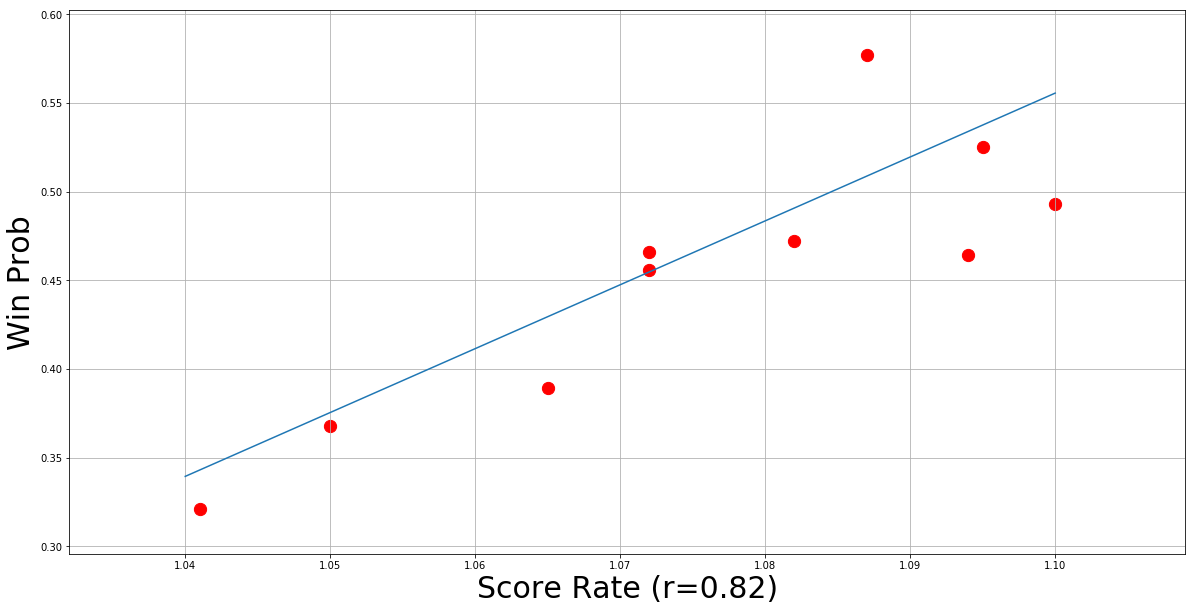

In [51]:
#Plotting scatter of win rate, score rate, line of best fit

plt.rcParams["figure.figsize"] = (20,10)

z= (np.array(season_agg.score_rate))
y= np.array(season_agg.win_rate)
plt.scatter(z, y, c='r', s=150)
n= np.array(season_agg.index)
plt.plot([1.04,1.1], [-2.87 + 3.086*1.04, -2.87 + 3.086*1.11] )

plt.xlabel('Score Rate (r=0.82)', size= 30)
plt.ylabel('Win Prob', size=30)

plt.grid(True)


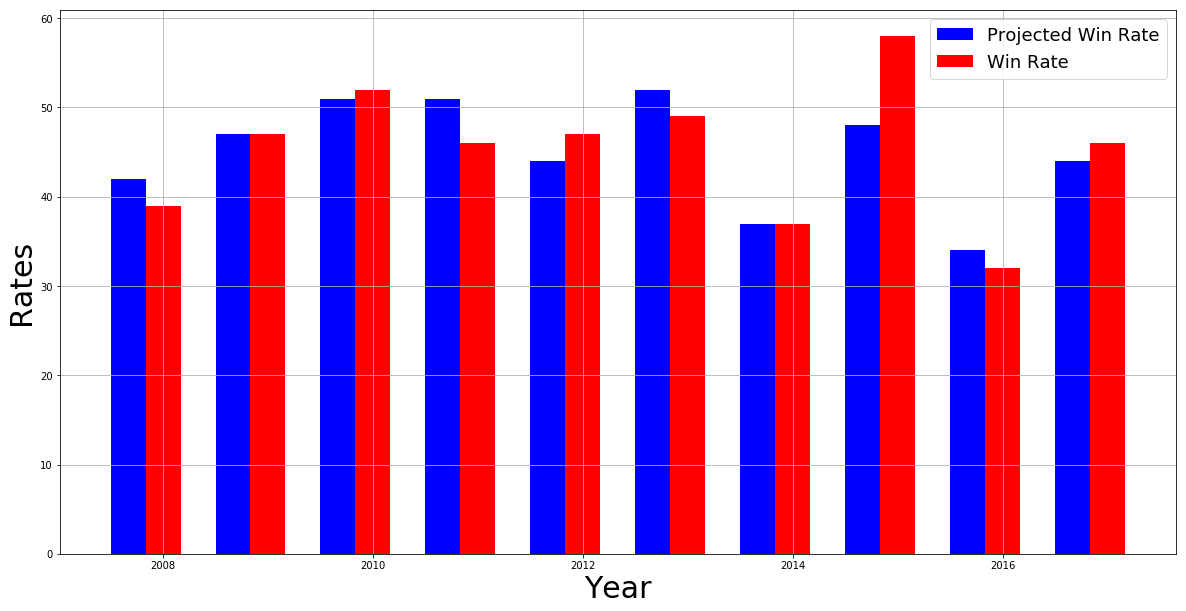

In [52]:
#Bar Chart Showing how good the estimate is 
#Biggest error is around 10%, which is roughly 5 games, not a lot of deviation

score_rates = np.round(100*(.216 + 3.086*(np.array(season_agg.score_rate)-1)))

win_rates = np.round(100*(np.array(season_agg.win_rate)))
indices = np.array(season_agg.index)
width= np.ones(len(indices))/3
#Calculate optimal width

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width,score_rates,width, color='b',label='-Ymin')
ax.bar(indices,win_rates,width, color='r', label='Ymax')
ax.set_xlabel('Year', size=30)
ax.set_ylabel('Rates', size=30)
plt.grid(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Projected Win Rate', 'Win Rate'], prop={'size': 18})

plt.show()

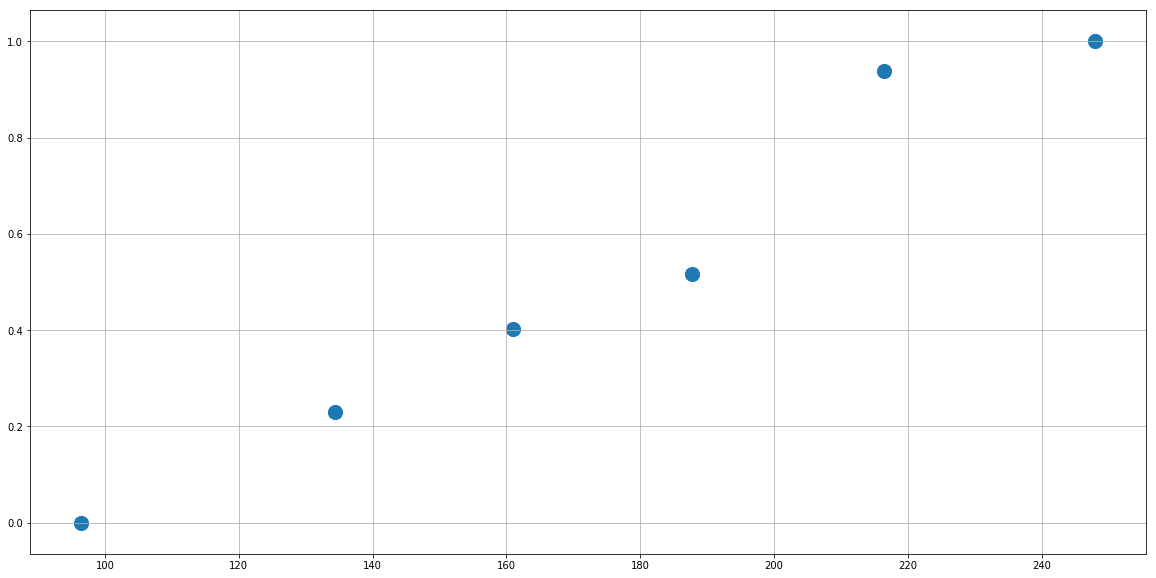

In [55]:
#Some points showing how likely you are to win with certain scores batting first, 2014 and after
no_rain['run_group']= pd.cut(no_rain.innings1, [0,115,145,175,205,235,300])
win_group= no_rain[no_rain.season>2013.5].groupby('run_group').mean()[['innings1', 'adj_inn2', 'win']]
plt.scatter(win_group.innings1, win_group.win, s=200)
plt.grid(True)
